# Visualization of true covariance matrix

Based 45,000 mcmc posterior draws from Joshua Chan's stochastic volatility in mean model circulated by David.

Model form:
$$y_t    = \tau_t + \alpha_t \exp(h_t) + e_t,\quad e_t \sim N(0,\exp(h_t)),$$
$$h_t    = mu + \phi (h_{t-1}-\mu) + \beta y_{t-1}+ v_t, \quad v_t \sim N(0,\sigma^2),$$

$$\gamma_t = (\alpha_t, \tau_t)'$$
$$\gamma_t = \gamma_{t-1} + w_t, \quad w_t \sim N(0,\Omega)$$

Initial conditions: 
$$\tau_1 \sim N(0,V_\tau),\quad h_1 \sim N(\mu,\sigma^2/(1-\phi^2)).$$

Chan, J.C.C. (2017). The Stochastic Volatility in Mean Model with
Time-Varying Parameters: An Application to Inflation Modeling, 
Journal of Business and Economic Statistics, 35(1), 17-28.

Note: all visualizations are truncated at some arbitrary quantile (1%).

**Preview of results**: a sparse posterior precision matrix of the type we have discussed isn't actually such a bad parameterization. Most non-diagonal, non-global values are relatively close to zero.

## Set up code

In [1]:
from autograd import numpy as np
from sparse_vi.svm import SVM
from sparse_vi.jchan import SVMDraws
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
samples = SVMDraws.load('USCPI_samples.p')
samples.summary()

,Mean,5%,95%
μ,0.159058,-0.823779,0.990234
β,0.003401,-0.005360,0.012733
φ,0.949219,0.901367,0.989258
σ²,0.089661,0.049988,0.147827
Ω_α,0.041687,0.013130,0.099426
Ω_ατ,0.010017,-0.031831,0.052338
Ω_τ,0.119324,0.053406,0.226074


We'll define two covariance matrices. $Σ_1 = E\left[η_1^\topη_1\right]$ keeps each set of local variables together, with global variables in the bottom-right corner. Here, we have 
$$η_1 = (α_{1:T}^\top,t_{1:T}^\top,h_{1:T}^\top,θ^\top).$$
The alternative covariance matrix $Σ_2 = E\left[η_2^\topη_2\right]$ groups local parameters by time step,
$$η_2 = (α_1^\top,τ_1^\top,h_1^\top,\dots,α_T^\top,τ_T^\top,h_T^\top,θ^\top).$$

In [3]:
η1 = np.bmat([samples.alpha, samples.tau, samples.h, samples.theta]
            ).astype(np.float64)
assert np.all(np.isfinite(η1)), 'Some draws not finite'
n, k = η1.shape
Σ_1 = η1.T@η1/(n-k)
assert Σ_1.shape == (k, k)
assert np.sum(np.bitwise_not(np.isfinite(Σ_1))) == 0

In [4]:
localvars = np.array([samples.alpha.T, samples.tau.T, samples.h.T])
η2 = np.bmat([localvars.reshape(-1, localvars.shape[2], order='F').T,
              samples.theta]).astype(np.float64)
Σ_2 = η2.T@η2/(n-k)
assert Σ_2.shape == (k, k)
assert np.sum(np.bitwise_not(np.isfinite(Σ_2))) == 0

In [5]:
def plot_matrix(A, name, title='', truncate_pc=None):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    if truncate_pc:
        lower, upper = np.percentile(a=A, q=[truncate_pc/2, 100.-truncate_pc/2])
        A = np.minimum(np.maximum(np.copy(A), lower), upper)
    plt.imshow(A)
    plt.title(f'Matrix ${name}$')
    plt.subplot(122)
    support = np.linspace(np.min(A), np.max(A), 200)
    f_all = stats.gaussian_kde(np.array(A).flatten())
    plt.plot(support, f_all(support), label='All')
    f_diag = stats.gaussian_kde(np.diag(A).flatten())
    plt.plot(support, f_diag(support), label='Diagonal')
    plt.legend()
    plt.title(f'${name}$ entry distribution')
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show();

## Posterior covariance matrix

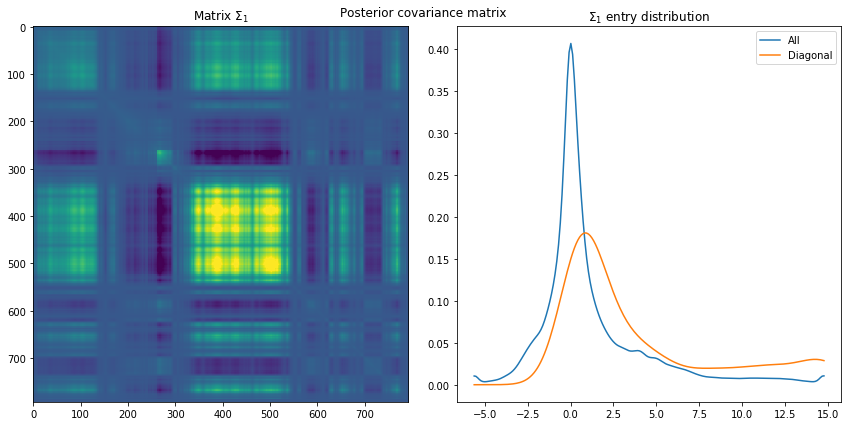

In [6]:
plot_matrix(Σ_1, 'Σ_1', 'Posterior covariance matrix',
            truncate_pc=1.)

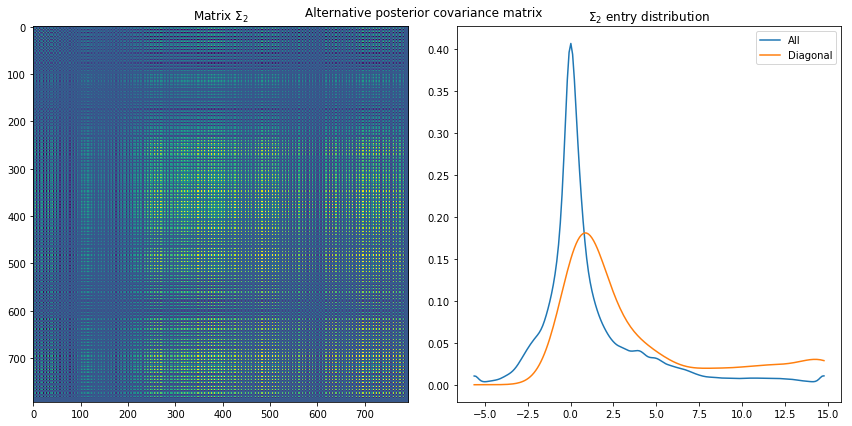

In [7]:
plot_matrix(Σ_2, 'Σ_2', 'Alternative posterior covariance matrix',
            truncate_pc=1.)

### Cholesky factor

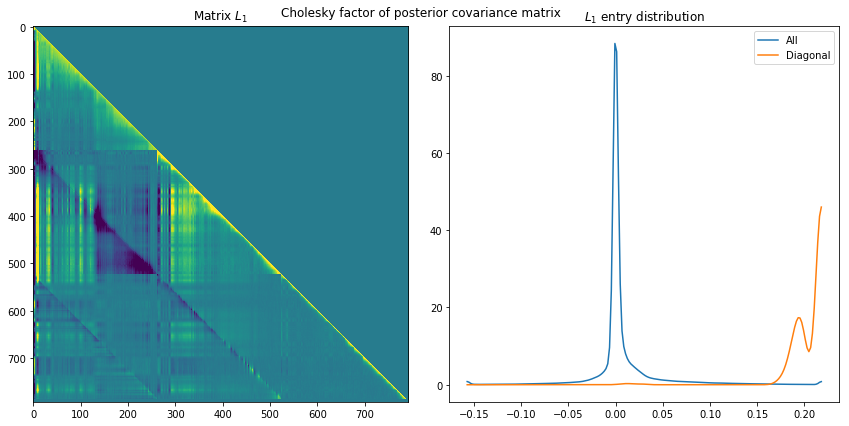

In [8]:
L_1 = np.linalg.cholesky(Σ_1)
plot_matrix(L_1, 'L_1', 'Cholesky factor of posterior covariance matrix',
           truncate_pc=1.);

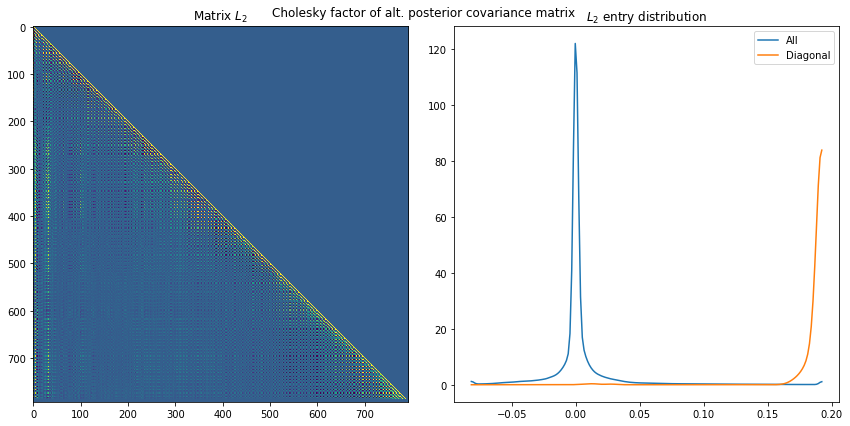

In [9]:
L_2 = np.linalg.cholesky(Σ_2)
plot_matrix(L_2, 'L_2', 'Cholesky factor of alt. posterior covariance matrix',
           truncate_pc=1.);

## Precision matrix

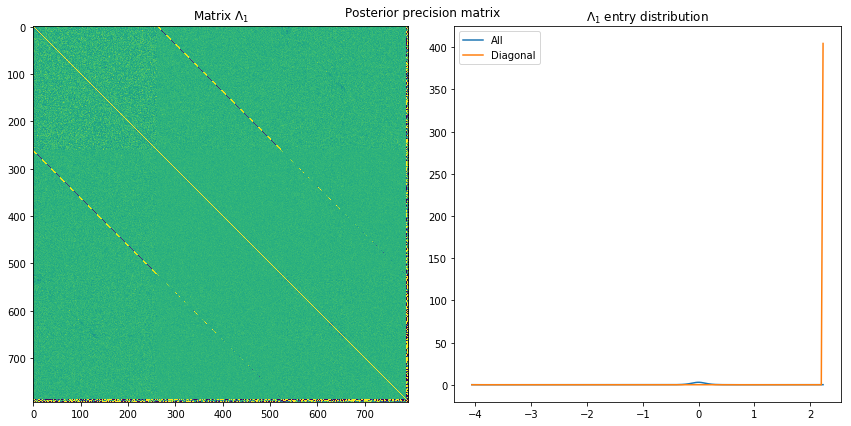

In [10]:
Λ_1 = np.linalg.pinv(Σ_1)
plot_matrix(Λ_1, 'Λ_1', r'Posterior precision matrix',
           truncate_pc=1.);

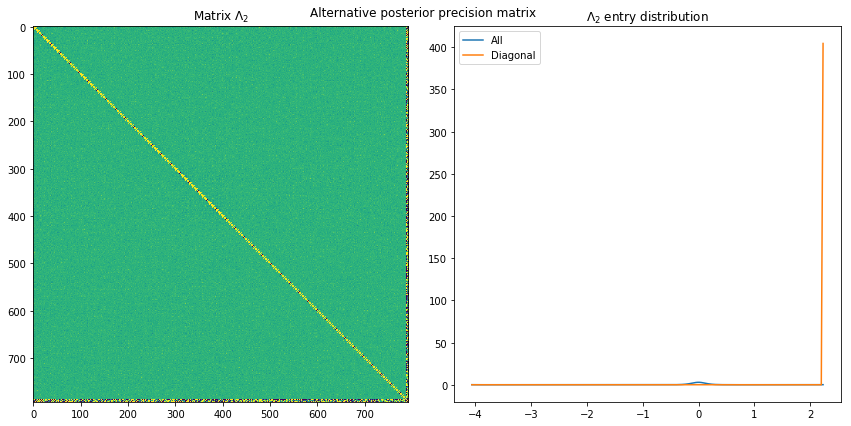

In [11]:
Λ_2 = np.linalg.pinv(Σ_2)
plot_matrix(Λ_2, 'Λ_2', r'Alternative posterior precision matrix',
           truncate_pc=1.);

### Cholesky factor

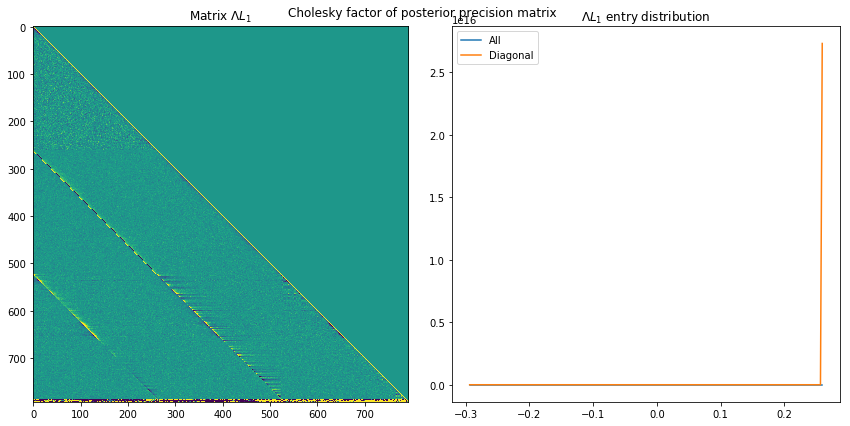

In [12]:
ΛL_1 = np.linalg.cholesky(Λ_1)
plot_matrix(ΛL_1, 'ΛL_1', 'Cholesky factor of posterior precision matrix',
           truncate_pc=1.);

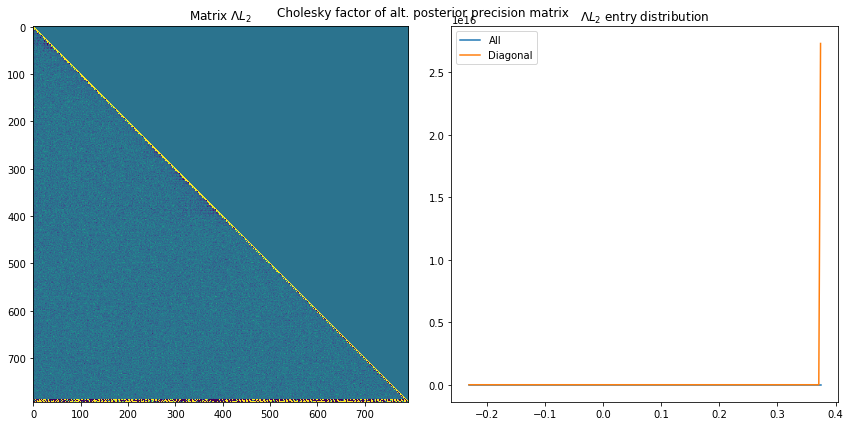

In [13]:
ΛL_2 = np.linalg.cholesky(Λ_2)
plot_matrix(ΛL_2, 'ΛL_2', 'Cholesky factor of alt. posterior precision matrix',
           truncate_pc=1.);